<a href="https://colab.research.google.com/github/MuktaUbale/comparing-VITs/blob/main/regular_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip -q install vit_pytorch linformer


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [13]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import torch.optim as optim

from vit_pytorch.efficient import ViT

In [14]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [15]:
print(f"Torch: {torch.__version__}")

Torch: 2.1.1+cu121


In [16]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [17]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [18]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


In [19]:
os.makedirs('data', exist_ok=True)

train_dir = 'data/train'
test_dir = 'data/test'

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transforms)

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=val_transforms)

val_size = 0.2
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(val_size * num_train))

np.random.seed(seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [20]:
num_train = len(train_dataset)
num_test = len(test_dataset)
print(num_train, num_test)

50000 10000


In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           sampler=train_sampler, pin_memory=True,)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                           sampler=val_sampler, pin_memory=True,)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [22]:
print(len(train_loader), len(val_loader), len(test_loader))

625 157 157


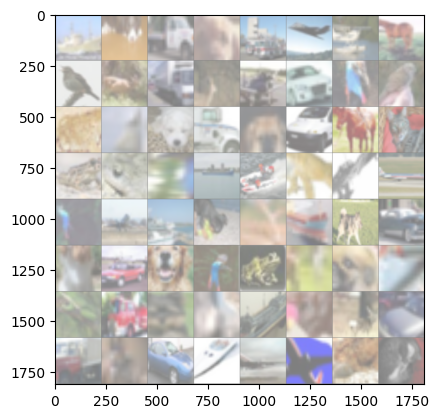

ship               dog                truck              dog                truck              plane              plane              horse              bird               deer               truck              deer               plane              car                bird               bird               frog               ship               dog                truck              dog                car                horse              cat                frog               frog               bird               ship               ship               frog               plane              plane              bird               plane              ship               dog                deer               ship               dog                car                dog                car                dog                bird               frog               deer               dog                plane              frog               truck              dog                bird               ship        

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:18s}' for j in range(batch_size)))

# Efficient Attention

## Linformer

In [26]:
heads = [2, 4, 8, 16, 32, 64]
models = []

In [27]:
for head in heads:
  efficient_transformer = Linformer(
      dim=128,
      seq_len=49 + 1,
      depth=12,
      heads=head,
      k=64
  )

  model = ViT(
      dim=128,
      image_size=224,
      patch_size=32,
      num_classes=10,
      transformer=efficient_transformer,
      channels=3,
  ).to(device)

  models += [model]

In [28]:
len(models)

6

# Training

In [29]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [30]:
train_losses = []
val_losses = []

for model in models:

  training_loss = []
  validation_loss = []

  for epoch in range(epochs):
      epoch_loss = 0
      epoch_accuracy = 0
      running_loss = 0.0

      for i, data in enumerate(train_loader, 0):
          inputs, labels = data[0].to(device), data[1].to(device)
          # data = data.to(device)
          # label = label.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          output = model(inputs)
          loss = criterion(output, labels)
          loss.backward()
          optimizer.step()

          acc = (output.argmax(dim=1) == labels).float().mean()
          epoch_accuracy += acc / len(train_loader)
          epoch_loss += loss / len(train_loader)

          # print statistics
          running_loss += loss.item()
          if i % 200 == 199:    # print every 200 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0

      print(f'Epoch {epoch}')

      with torch.no_grad():
          epoch_val_accuracy = 0
          epoch_val_loss = 0
          for data, label in val_loader:
              data = data.to(device)
              label = label.to(device)

              val_output = model(data)
              val_loss = criterion(val_output, label)

              acc = (val_output.argmax(dim=1) == label).float().mean()
              epoch_val_accuracy += acc / len(val_loader)
              epoch_val_loss += val_loss / len(val_loader)

      training_loss.append(epoch_loss.cpu().detach())
      validation_loss.append(epoch_val_loss.cpu().detach())

      print(
          f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
      )

  train_losses += [training_loss]
  val_losses += [validation_loss]


[1,   200] loss: 0.240
[1,   400] loss: 0.239
[1,   600] loss: 0.241
Epoch 0
Epoch : 1 - loss : 2.4017 - acc: 0.1002 - val_loss : 2.4046 - val_acc: 0.0992

[2,   200] loss: 0.240
[2,   400] loss: 0.241
[2,   600] loss: 0.240
Epoch 1
Epoch : 2 - loss : 2.4017 - acc: 0.1002 - val_loss : 2.4039 - val_acc: 0.0995

[3,   200] loss: 0.241
[3,   400] loss: 0.240
[3,   600] loss: 0.240
Epoch 2
Epoch : 3 - loss : 2.4017 - acc: 0.1002 - val_loss : 2.4053 - val_acc: 0.0992

[4,   200] loss: 0.240
[4,   400] loss: 0.240
[4,   600] loss: 0.240
Epoch 3
Epoch : 4 - loss : 2.4017 - acc: 0.1002 - val_loss : 2.4049 - val_acc: 0.0989

[5,   200] loss: 0.240
[5,   400] loss: 0.240
[5,   600] loss: 0.241
Epoch 4
Epoch : 5 - loss : 2.4017 - acc: 0.1002 - val_loss : 2.4037 - val_acc: 0.0995

[6,   200] loss: 0.240
[6,   400] loss: 0.240
[6,   600] loss: 0.241
Epoch 5
Epoch : 6 - loss : 2.4017 - acc: 0.1001 - val_loss : 2.4044 - val_acc: 0.0995

[7,   200] loss: 0.240
[7,   400] loss: 0.240
[7,   600] loss: 0

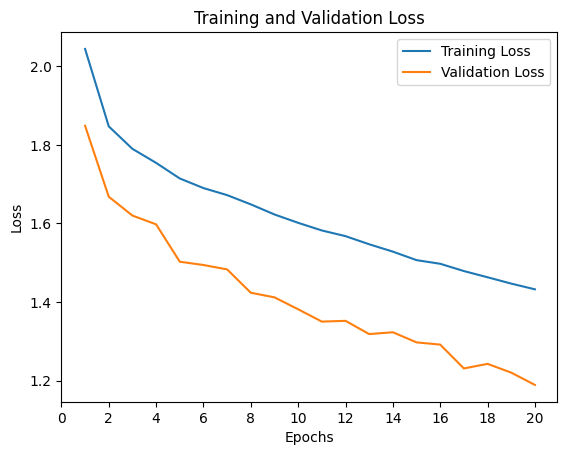

In [47]:
from pickle import load
from matplotlib.pylab import plt
from numpy import arange

heads_index = 5

train_values = train_losses[heads_index]
val_values = val_losses[heads_index]

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 21)

# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 21, 2))

# Display the plot
plt.legend(loc='best')
plt.show()

# Vary Number of Heads, Linformer

In [ ]:
## Vary num heads, keep patch size constant

patch_size = 16  # Keep patch size constant
num_heads_list = [2, 4, 8, 16, 32]  # Vary the number of heads
seq_len = 197 

models = []

for num_heads in num_heads_list:
    # Create Linformer with varied number of heads
    efficient_transformer = Linformer(
        dim=128,
        seq_len=seq_len,
        depth=12,
        heads=num_heads,
        k=64
    )

    model = ViT(
        dim=128,
        image_size=224,
        patch_size=patch_size,
        num_classes=10,
        transformer=efficient_transformer,
        channels=3,
    ).to(device)

    models.append(model)


In [ ]:
len(models)

# Vary Number of Heads, Training

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

####

train_losses = []
val_losses = []

for model in models:

  training_loss = []
  validation_loss = []

  for epoch in range(epochs):
      epoch_loss = 0
      epoch_accuracy = 0
      running_loss = 0.0

      for i, data in enumerate(train_loader, 0):
          inputs, labels = data[0].to(device), data[1].to(device)
          # data = data.to(device)
          # label = label.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          output = model(inputs)
          loss = criterion(output, labels)
          loss.backward()
          optimizer.step()

          acc = (output.argmax(dim=1) == labels).float().mean()
          epoch_accuracy += acc / len(train_loader)
          epoch_loss += loss / len(train_loader)

          # print statistics
          running_loss += loss.item()
          if i % 200 == 199:    # print every 200 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0

      print(f'Epoch {epoch}')

      with torch.no_grad():
          epoch_val_accuracy = 0
          epoch_val_loss = 0
          for data, label in val_loader:
              data = data.to(device)
              label = label.to(device)

              val_output = model(data)
              val_loss = criterion(val_output, label)

              acc = (val_output.argmax(dim=1) == label).float().mean()
              epoch_val_accuracy += acc / len(val_loader)
              epoch_val_loss += val_loss / len(val_loader)

      training_loss.append(epoch_loss.cpu().detach())
      validation_loss.append(epoch_val_loss.cpu().detach())

      print(
          f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
      )

  train_losses += [training_loss]
  val_losses += [validation_loss]


## Vary number of heads, plotting results

In [ ]:
from matplotlib import pyplot as plt
from numpy import arange

epochs = range(1, 21)

for i, model in enumerate(models):
    train_values = train_losses[i]
    val_values = val_losses[i]

    plt.plot(epochs, train_values, label=f'Training Loss (Heads: {num_heads_list[i]})')
    plt.plot(epochs, val_values, label=f'Validation Loss (Heads: {num_heads_list[i]})')

plt.title('Training and Validation Loss for Different Numbers of Heads')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(arange(0, 21, 2))

plt.legend()

plt.show()

NameError: name 'models' is not defined